<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 21.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is inco

In [2]:
import fastai
print(fastai.__version__)

2.0.19


In [41]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from functools import partial

from fastcore.transform import Pipeline

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, MultiCategoryBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, RegexLabeller, Normalize

from fastai.metrics import accuracy_multi, BCEWithLogitsLossFlat

from fastai.vision.augment import RandomResizedCrop, aug_transforms
from fastai.vision.core import get_image_files, PILImage
from fastai.vision.data import ImageBlock, imagenet_stats
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34

In [4]:
path = untar_data(URLs.PETS)/'images'

In [69]:
path

Path('/root/.fastai/data/oxford-iiit-pet/images')

In [5]:
len(path.ls())

7393

In [6]:
path.ls()[:3]

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_149.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_108.jpg')]

In [20]:
pets_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(),
            get_y=Pipeline([RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'), lambda label: [label]]),
            item_tfms=RandomResizedCrop(460, min_scale=0.75),
            batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [21]:
dls = pets_multi.dataloaders(untar_data(URLs.PETS)/"images",  bs=32)

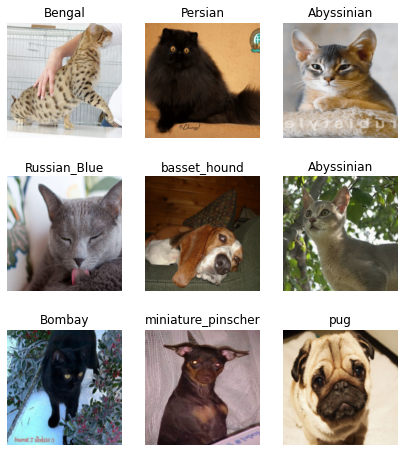

In [22]:
dls.show_batch(max_n=9, figsize=(7,8))

In [23]:
learn = cnn_learner(dls, resnet34, pretrained=True, 
                    metrics=[partial(accuracy_multi, thresh=0.95)], 
                    loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [24]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 32 x 64 x 56 x 56    0          False     
_________________________________________________

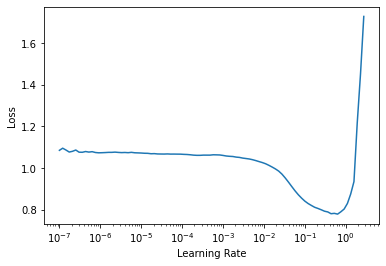

In [25]:
lr_min,lr_steep = learn.lr_find()

In [26]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 6.31e-02, steepest point: 3.98e-02


In [27]:
learn.fit_one_cycle(5, lr_max=6.31e-02, 
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2),
                        ReduceLROnPlateau(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.127895,0.152242,0.974491,01:31
1,0.067736,0.052337,0.980489,01:33
2,0.060364,0.045120,0.981549,01:31
3,0.038872,0.024209,0.984658,01:30
4,0.024362,0.017466,0.987529,01:29


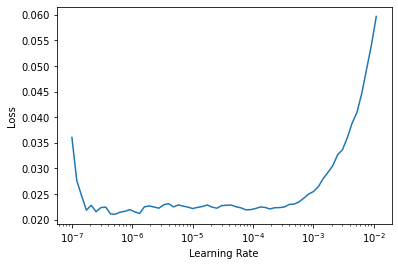

In [28]:
learn.unfreeze()

lr_min,lr_steep = learn.lr_find()

In [30]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")


Minimum/10: 1.32e-07, steepest point: 3.98e-06


In [31]:
learn.fit_one_cycle(20, lr_max=1.32e-07, 
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2),
                        ReduceLROnPlateau(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.022950,0.017478,0.987602,01:40
1,0.022511,0.017621,0.987620,01:39
2,0.021464,0.017157,0.987474,01:40
3,0.021349,0.016985,0.987657,01:40
4,0.022113,0.017098,0.987584,01:39
5,0.022495,0.017250,0.987858,01:37


No improvement since epoch 3: early stopping


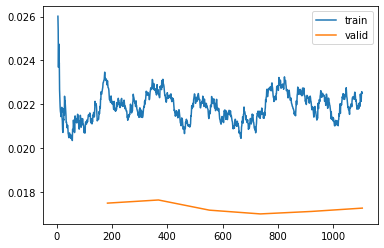

In [32]:
learn.recorder.plot_loss()

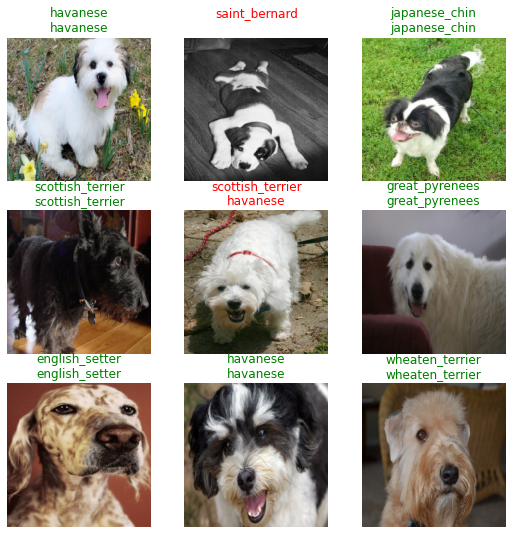

In [36]:
learn.show_results()

In [62]:
# learn.export('/content/gdrive/MyDrive/models/pets1.pkl')

In [59]:
pwd

'/content'

In [63]:
# inf_learner = load_learner('/content/gdrive/MyDrive/models/pets.pkl')

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,yorkshire_terrier,havanese,"tensor([1.9947e-06, 2.5867e-05, 8.0928e-05, 1.2805e-05, 1.5207e-05, 2.5316e-04,\n 7.2366e-04, 9.0988e-05, 2.8573e-06, 3.3860e-07, 5.8505e-07, 6.0236e-08,\n 5.3491e-05, 5.7270e-06, 2.1568e-06, 1.4064e-05, 8.6647e-06, 4.8226e-06,\n 7.1979e-05, 2.1153e-04, 5.1042e-05, 2.0623e-05, 9.9221e-01, 1.7892e-03,\n 7.6621e-05, 1.8059e-05, 3.9055e-06, 5.6809e-04, 4.5660e-06, 5.8383e-04,\n 1.0370e-05, 8.7143e-07, 9.0988e-05, 4.3477e-07, 1.0699e-05, 6.3868e-04,\n 3.5281e-04])",0.346229612827301
1,scottish_terrier,havanese,"tensor([2.5559e-07, 3.6612e-07, 2.1783e-05, 8.2332e-08, 4.2470e-07, 1.2315e-05,\n 2.8573e-06, 9.5909e-06, 1.5903e-06, 4.6184e-08, 2.9819e-08, 8.6284e-08,\n 9.8381e-05, 2.8797e-06, 1.1818e-06, 2.6220e-06, 7.6305e-07, 1.8487e-05,\n 5.3491e-05, 9.3491e-07, 4.8125e-07, 6.9222e-05, 9.9769e-01, 3.2632e-06,\n 3.0179e-06, 1.8994e-07, 2.5613e-06, 1.3212e-05, 2.1692e-07, 5.3382e-06,\n 2.4773e-07, 1.9526e-05, 2.7469e-03, 3.4663e-07, 1.2706e-05, 3.2101e-02,\n 1.3846e-05])",0.32440274953842163
2,english_cocker_spaniel,newfoundland,"tensor([3.3145e-06, 8.5972e-06, 1.1818e-06, 2.9541e-05, 1.6315e-05, 9.4963e-07,\n 3.6765e-05, 9.1325e-07, 7.6904e-07, 8.5972e-06, 8.2506e-07, 8.9023e-08,\n 3.0352e-07, 7.3792e-04, 1.0594e-06, 1.2124e-05, 3.0116e-07, 2.2508e-08,\n 1.7577e-02, 7.0312e-05, 5.4693e-03, 2.0027e-04, 1.2436e-04, 5.3800e-06,\n 1.2581e-06, 6.5917e-06, 4.9757e-06, 9.9946e-01, 7.6465e-06, 1.1366e-06,\n 1.0209e-05, 1.6315e-05, 1.4768e-04, 6.5267e-07, 3.9821e-04, 5.7719e-06,\n 1.6281e-06])",0.31266459822654724
3,german_shorthaired,beagle,"tensor([4.4694e-05, 1.3658e-04, 6.9054e-04, 5.1442e-05, 8.8189e-05, 4.6113e-05,\n 2.8241e-04, 1.4064e-05, 1.1235e-04, 1.2607e-05, 2.4346e-04, 3.8150e-06,\n 1.5793e-03, 2.4534e-03, 4.1988e-03, 7.3450e-01, 1.0473e-04, 9.1256e-03,\n 2.3735e-02, 2.7372e-04, 6.7618e-05, 3.1975e-03, 1.0902e-03, 8.6261e-04,\n 9.3146e-05, 1.8200e-05, 2.0911e-03, 3.0007e-05, 2.3322e-03, 1.2932e-04,\n 1.5793e-03, 1.6865e-04, 2.1824e-04, 3.1115e-03, 1.2100e-02, 5.2662e-05,\n 9.8501e-04])",0.29728275537490845
4,saint_bernard,boxer,"tensor([4.0843e-07, 8.4639e-06, 1.2679e-06, 3.9587e-07, 7.9053e-05, 7.6305e-07,\n 8.1227e-07, 2.7911e-06, 5.2554e-06, 8.5972e-06, 2.5613e-06, 4.4001e-05,\n 1.5073e-02, 2.1742e-03, 5.6148e-04, 1.2256e-03, 9.8095e-01, 3.7853e-06,\n 5.0042e-07, 1.5057e-06, 3.1693e-05, 1.5025e-07, 5.7719e-06, 1.7062e-06,\n 5.1229e-07, 5.6824e-06, 5.7270e-06, 6.8400e-07, 1.1886e-07, 2.3414e-04,\n 1.2793e-03, 1.9183e-06, 4.3911e-06, 9.0098e-06, 6.6669e-03, 6.0018e-06,\n 2.5613e-06])",0.2877942621707916


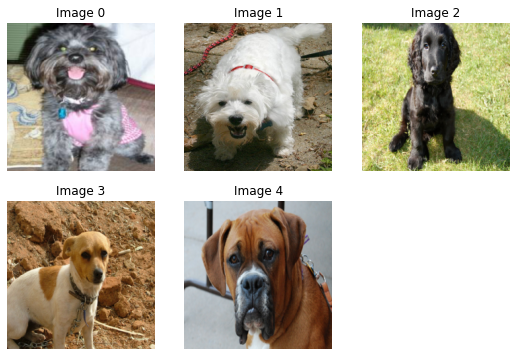

In [64]:
interp.plot_top_losses(k=5)

In [65]:
learn.loss_func=BCEWithLogitsLossFlat(thresh=0.95)

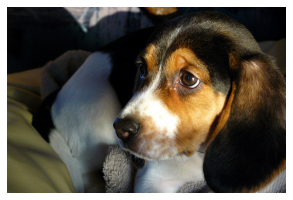

In [73]:
img = PILImage.create(path/'beagle_149.jpg')
img.show()

In [75]:
learn.predict(img)[0]

(#1) ['beagle']

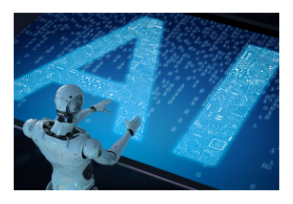

In [77]:
img = PILImage.create('/content/gdrive/MyDrive/models/ai.png')
img.show()

In [79]:
learn.predict(img)

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
 tensor([0.0033, 0.0054, 0.0031, 0.0354, 0.0152, 0.2124, 0.0040, 0.0012, 0.0094,
         0.1973, 0.0006, 0.0014, 0.0092, 0.0549, 0.0112, 0.0467, 0.0072, 0.0073,
         0.0035, 0.0027, 0.0391, 0.0032, 0.0015, 0.0044, 0.0026, 0.0008, 0.0036,
         0.0058, 0.0019, 0.0112, 0.0078, 0.0080, 0.0023, 0.0033, 0.0427, 0.0052,
         0.0019]))